#P3 Builder’s Guide (Section 6)
1. Implement a module that takes two modules as an argument, say net1 and net2 and
returns the concatenated output of both networks in the forward propagation. This
is also called a parallel module.
2. Assume that you want to concatenate multiple instances of the same network. Implement a factory function that generates multiple instances of the same module and
build a larger network from it.
3. Construct an MLP containing a shared parameter layer and train it. During the
training process, observe the model parameters and gradients of each layer.

In [2]:
#!pip install d2l==1.0.3

# d2l importing
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')

# libraries needed
import torch
from torch import nn
from torch.nn import functional as F
import d2l
from d2l import torch as d2l
import matplotlib.pyplot as plt
import torch.optim as optim


Mounted at /content/gdrive


# 1. Implement a module that takes two modules as an argument, say net1 and net2 and returns the concatenated output of both networks in the forward propagation. This is also called a parallel module.

In [ ]:
class MySequential(nn.Module):
    def __init__(self, *args):
        super().__init__()
        for idx, module in enumerate(args):
            self.add_module(str(idx), module)

    def forward(self, X):
        for module in self.children():
            X = module(X)
        return X

# Define modules
module1 = nn.Sequential(nn.LazyLinear(64), nn.ReLU())
module2 = nn.LazyLinear(64)

# Create a sequential model
sequential_model = MySequential(module1, module2)

# Print the modules added using add_module
for name, module in sequential_model.named_children():
    print(name, module)


0 Sequential(
  (0): LazyLinear(in_features=0, out_features=64, bias=True)
  (1): ReLU()
)
1 LazyLinear(in_features=0, out_features=64, bias=True)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


## Another way to do it? Feels messy

In [ ]:
# Define the first network
class YourFirstNetwork(nn.Module):
    def __init__(self):
        super(YourFirstNetwork, self).__init__()
        self.fc1 = nn.Linear(100, 50)
        self.fc2 = nn.Linear(50, 20)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define the second network
class YourSecondNetwork(nn.Module):
    def __init__(self):
        super(YourSecondNetwork, self).__init__()
        self.fc1 = nn.Linear(100, 30)
        self.fc2 = nn.Linear(30, 10)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define the ParallelModule
class ParallelModule(nn.Module):
    def __init__(self, net1, net2):
        super(ParallelModule, self).__init__()
        self.net1 = net1
        self.net2 = net2

    def forward(self, x):
        output1 = self.net1(x)
        output2 = self.net2(x)
        concatenated_output = torch.cat((output1, output2), dim=1)
        return concatenated_output

# Instantiate the networks
net1 = YourFirstNetwork()
net2 = YourSecondNetwork()

# Instantiate the ParallelModule
parallel_module = ParallelModule(net1, net2)

# Generate some dummy input data
batch_size = 32
input_channels = 100
input_height = 1
input_width = 1
input_data = torch.randn(batch_size, input_channels)

# Forward pass
output = parallel_module(input_data)

# Print the shape of the output tensor
print(output.shape)


torch.Size([32, 30])


#2. Assume that you want to concatenate multiple instances of the same network. Implement a factory function that generates multiple instances of the same module and build a larger network from it.

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        # Call the constructor of the parent class nn.Module to perform
        # the necessary initialization
        super().__init__()
        self.hidden = nn.LazyLinear(256)
        self.out = nn.LazyLinear(10)

    # Define the forward propagation of the model, that is, how to return the
    # required model output based on the input X
    def forward(self, X):
        return self.out(F.relu(self.hidden(X)))

class Factory(nn.Module):
    def __init__(self, func_class, k):
        super().__init__()
        modules = []
        for i in range(k):
            modules.append(func_class())  # Correctly instantiate the class
        self.net = nn.Sequential(*modules)

    def forward(self, X):
        return self.net(X)

net = Factory(MLP, 3)
X = torch.rand(2, 20)
out = net(X)

print(net)

Factory(
  (net): Sequential(
    (0): MLP(
      (hidden): Linear(in_features=20, out_features=256, bias=True)
      (out): Linear(in_features=256, out_features=10, bias=True)
    )
    (1): MLP(
      (hidden): Linear(in_features=10, out_features=256, bias=True)
      (out): Linear(in_features=256, out_features=10, bias=True)
    )
    (2): MLP(
      (hidden): Linear(in_features=10, out_features=256, bias=True)
      (out): Linear(in_features=256, out_features=10, bias=True)
    )
  )
)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#3. Construct an MLP containing a shared parameter layer and train it. During the training process, observe the model parameters and gradients of each layer.

## Creating a shared net and making sure it's shared


In [ ]:
n= 256
shared = nn.LazyLinear(n) # LAYERS
net = nn.Sequential(nn.LazyLinear(n), nn.ReLU(),
                    shared, nn.ReLU(),
                    shared, nn.ReLU(),
                    nn.LazyLinear(8), nn.ReLU())
X = torch.rand(2, 20)

net(X)
# Check whether the parameters are the same
# print(net[2].weight.data[0] == net[4].weight.data[0])
# net[2].weight.data[0, 0] = 100
# # Make sure that they are actually the same object rather than just having the
# # same value
# print(net[2].weight.data[0] == net[4].weight.data[0])

print(net)

Sequential(
  (0): Linear(in_features=20, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Linear(in_features=256, out_features=8, bias=True)
  (7): ReLU()
)


## Actual Model

In [12]:
class PlotParameterMLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr, dropouts):
        super().__init__()
        self.save_hyperparameters()
        layers = [nn.Flatten(),nn.LazyLinear(num_hiddens[0]),nn.ReLU()]
        shared = nn.LazyLinear(num_hiddens[1])
        self.activations = []
        for i in range(1,len(num_hiddens)):
            layers.append(shared)
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropouts[i]))
            self.activations.append(i*3)
        layers.append(nn.LazyLinear(num_outputs))
        self.net = nn.Sequential(*layers)

    def training_step(self, batch, plot_flag=True):
        y_hat = self(*batch[:-1])
        if plot_flag:
            for i in self.activations:
                # print(self.net[i].weight.data,self.net[i].weight.grad)
                self.plot(f'layer_{i}_weight',self.net[i].weight.data.mean(),train=True)
                # self.plot(f'layer_{i}_weight',self.net[i].weight.grad.mean(),train=True)
        return self.loss(y_hat, batch[-1])

    def validation_step(self, batch, plot_flag=True):
        y_hat = self(*batch[:-1])
        if plot_flag:
            for i in self.activations:
                # self.plot(f'layer_{i}_weight',self.net[i].weight.data.mean(),train=True)
                self.plot(f'layer_{i}_weight',self.net[i].weight.grad.mean(),train=True)
        return self.loss(y_hat, batch[-1])

    def stat_activation_variance(self, i, X):
         activation = self.net[:i](X)
         return ((activation-activation.mean(axis=0,keepdim=True))**2).mean()


PlotParameterMLP(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=8, bias=True)
    (2): ReLU()
    (3): Linear(in_features=8, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0, inplace=False)
    (6): Linear(in_features=8, out_features=8, bias=True)
    (7): ReLU()
    (8): Dropout(p=0, inplace=False)
    (9): Linear(in_features=8, out_features=10, bias=True)
  )
)


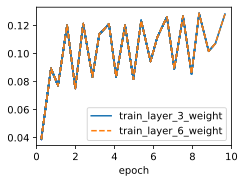

In [14]:
data = d2l.FashionMNIST(batch_size=256)
hparams = {'num_outputs':10,'num_hiddens':[8]*3,
           'dropouts':[0]*3,'lr':0.1}
model = PlotParameterMLP(**hparams)

trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

print(model)